## This is an analysis on a dataset http://archive.ics.uci.edu/ml/datasets/Diabetes+130-US+hospitals+for+years+1999-2008 containing patient information from 10 years across 130 hospitals. Dataset description is here https://www.hindawi.com/journals/bmri/2014/781670/tab1/

### Patients in the dataset have at least one diabetes related diagnosis. The goal is to predict if a patient will be readmitted to the hospital in under 30 days.

In [138]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', 400)
from sklearn.preprocessing import Binarizer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression


%matplotlib inline
import scipy

import re


import traceback
import sys
import getpass
import argparse
from datetime import date
import time
import logging
import random

import io


from rfpimp import *
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedKFold, RepeatedStratifiedKFold, StratifiedShuffleSplit
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer



### There are two mapping tables and one dataset table.

In [6]:
#this table is complex because it has a number of id types
dfmap = pd.read_csv('data/IDS_mapping.csv') 
diag_new = pd.read_csv('data/cms_hcc_icd9_abbrev.csv')

In [7]:
#higher level groupings for diagnoses to lower dimensions
diag_new.head()

,icd9_abbrev,condition,n_code,max_n_code
0,003,Bone/Joint/Muscle Infections/Necrosis,2,2
1,006,"Pneumococcal Pneumonia, Empyema, Lung Abscess",1,1
2,007,Opportunistic Infections,1,1
3,020,"Pneumococcal Pneumonia, Empyema, Lung Abscess",3,3
4,021,"Pneumococcal Pneumonia, Empyema, Lung Abscess",1,1


In [8]:
dfmap.head()

,admission_type_id,description
0,1,Emergency
1,2,Urgent
2,3,Elective
3,4,Newborn
4,5,Not Available


In [9]:
df = pd.read_csv('data/diabetic_data.csv')

In [10]:
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,?,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,?,?,1,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,?,?,59,0,18,0,0,0,276,250.01,255,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,?,?,11,5,13,2,0,1,648,250,V27,6,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,?,?,44,1,16,0,0,0,8,250.43,403,7,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,51,0,8,0,0,0,197,157,250,5,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [14]:
#look at the data, this table actually has data which maps to three different columns in the main dataset
dfmap.admission_type_id.unique()

array(['1', '2', '3', '4', '5', '6', '7', '8', nan,
       'discharge_disposition_id', '9', '10', '11', '12', '13', '14',
       '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25',
       '26', '30', '27', '28', '29', 'admission_source_id'], dtype=object)

In [12]:
#patients are in this data many times but we do not know chronologically where they fall since encounter id isn't increasing with time
df.patient_nbr.value_counts().head()

88785891    40
43140906    28
23199021    23
1660293     23
88227540    23
Name: patient_nbr, dtype: int64

### going to join and clean the data and then do some exploring before predicting

In [15]:
#separate id types to three different tables
dfadmin = dfmap[:8]
dfadmin.head()

,admission_type_id,description
0,1,Emergency
1,2,Urgent
2,3,Elective
3,4,Newborn
4,5,Not Available


In [29]:
dfdispo = dfmap[10:40]
dfdispo.columns =['discharge_disposition_id','description']
dfdispo.head()

,discharge_disposition_id,description
10,1,Discharged to home
11,2,Discharged/transferred to another short term h...
12,3,Discharged/transferred to SNF
13,4,Discharged/transferred to ICF
14,5,Discharged/transferred to another type of inpa...


In [30]:
dfsource = dfmap[42:]
dfsource.columns = ['admission_source_id','description']
dfsource.head()

,admission_source_id,description
42,1,Physician Referral
43,2,Clinic Referral
44,3,HMO Referral
45,4,Transfer from a hospital
46,5,Transfer from a Skilled Nursing Facility (SNF)


In [18]:
type(dfmap['admission_type_id'].iloc[0])


str

In [19]:
type(df['admission_type_id'].iloc[0])  #in order to join I wil have to convert the ids to the same data type

numpy.int64

In [20]:
#can't join the tables until the ids are the same data type
df['admission_type_id'] = df['admission_type_id'].astype('str')
df['discharge_disposition_id'] = df['discharge_disposition_id'].astype('str')
df['admission_source_id'] =df['admission_source_id'].astype('str')

In [22]:
#join the two tables to get admission type
dfjoin1 = df.merge(dfadmin, how = 'left', on = ['admission_type_id'])
dfjoin1.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,description
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,?,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,?,?,1,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO,NaN
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,?,?,59,0,18,0,0,0,276,250.01,255,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,>30,Emergency
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,?,?,11,5,13,2,0,1,648,250,V27,6,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO,Emergency
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,?,?,44,1,16,0,0,0,8,250.43,403,7,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO,Emergency
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,51,0,8,0,0,0,197,157,250,5,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO,Emergency


In [23]:
dfjoin1.rename(columns={'description':'admission_type_desc'}, inplace=True)

In [32]:
#join again to get disposition and again to get source of admission
dfjoin2 = dfjoin1.merge(dfdispo, how = 'left', on = ['discharge_disposition_id'])

In [33]:
dfjoin2.rename(columns={'description':'discharge_disposition_desc'}, inplace=True)

In [34]:
#join again to get disposition and again to get source of admission
dfjoin3 = dfjoin2.merge(dfsource, how = 'left', on = ['admission_source_id'])

In [35]:
dfjoin3.rename(columns={'description':'admission_source_desc'}, inplace=True)

In [37]:
dfjoin3.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,admission_type_desc,discharge_disposition_desc,admission_source_desc
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,?,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,?,?,1,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO,NaN,Not Mapped,Physician Referral
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,?,?,59,0,18,0,0,0,276,250.01,255,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,>30,Emergency,Discharged to home,Emergency Room
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,?,?,11,5,13,2,0,1,648,250,V27,6,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO,Emergency,Discharged to home,Emergency Room
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,?,?,44,1,16,0,0,0,8,250.43,403,7,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO,Emergency,Discharged to home,Emergency Room
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,51,0,8,0,0,0,197,157,250,5,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO,Emergency,Discharged to home,Emergency Room


In [38]:
dfjoin3.shape

(101766, 53)

In [39]:
len(dfjoin3), len(dfjoin3.drop_duplicates()) #checking for duplicates

(101766, 101766)

In [40]:
dfjoin3.admission_type_desc.unique()

array([nan, 'Emergency', 'Urgent', 'Elective', 'Newborn', 'Not Available',
       'Not Mapped', 'Trauma Center'], dtype=object)

In [41]:
dfjoin3.discharge_disposition_desc.unique() 
# how many people died? this could be used in validation, these patients should not be readmitted

array(['Not Mapped', 'Discharged to home',
       'Discharged/transferred to SNF',
       'Discharged/transferred to home with home health service',
       'Discharged/transferred to another short term hospital',
       'Discharged/transferred to another type of inpatient care institution',
       'Expired', 'Left AMA',
       'Neonate discharged to another hospital for neonatal aftercare',
       'Discharged/transferred to ICF', 'Hospice / medical facility', nan,
       'Discharged/transferred to home under care of Home IV provider',
       'Hospice / home',
       'Still patient or expected to return for outpatient services',
       'Discharged/transferred/referred another institution for outpatient services',
       'Discharged/transferred/referred to this institution for outpatient services',
       'Discharged/transferred to another rehab fac including rehab units of a hospital .',
       'Discharged/transferred to a long term care hospital.',
       'Admitted as an inpatient to t

In [46]:
#look at extreme worst cases where patients died. these can not get readmitted so perhaps exclude these from the model
len(dfjoin3[(dfjoin3['discharge_disposition_desc'].str.contains("Expired")) & (dfjoin3['discharge_disposition_desc'].notnull())])

1652

In [48]:
#exclude these from the data
terminating_encounters = dfjoin3[(dfjoin3['discharge_disposition_desc'].str.contains("Expired")) & (dfjoin3['discharge_disposition_desc'].notnull())].encounter_id.unique()

In [51]:
#exclude these from the data
dfjoin4 = dfjoin3[~dfjoin3['encounter_id'].isin(terminating_encounters)]

## one consideration, you might expect both the healthiest people to not be readmitted  but also for the sickest people who die to also not be readmitted.

## basic data cleaning: remove "." from dataset diagnosis codes to properly match with the mapping table. look at unique values for each column and the distribution across the data. clean age column to simple categories.

In [53]:
#weight is categorical
dfjoin4.weight.value_counts()

?            96958
[75-100)      1320
[50-75)        881
[100-125)      622
[125-150)      143
[25-50)         94
[0-25)          48
[150-175)       34
[175-200)       11
>200             3
Name: weight, dtype: int64

In [54]:
#age is categorical
dfjoin4.age.value_counts()

[70-80)     25562
[60-70)     22185
[50-60)     17102
[80-90)     16706
[40-50)      9626
[30-40)      3765
[90-100)     2668
[20-30)      1650
[10-20)       690
[0-10)        160
Name: age, dtype: int64

In [55]:
dfjoin4.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,admission_type_desc,discharge_disposition_desc,admission_source_desc
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,?,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,?,?,1,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO,NaN,Not Mapped,Physician Referral
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,?,?,59,0,18,0,0,0,276,250.01,255,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,>30,Emergency,Discharged to home,Emergency Room
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,?,?,11,5,13,2,0,1,648,250,V27,6,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO,Emergency,Discharged to home,Emergency Room
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,?,?,44,1,16,0,0,0,8,250.43,403,7,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO,Emergency,Discharged to home,Emergency Room
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,51,0,8,0,0,0,197,157,250,5,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO,Emergency,Discharged to home,Emergency Room


In [57]:
df_unique_demo = dfjoin4[['patient_nbr','race','gender','age','weight']].drop_duplicates()

In [61]:
df_unique_demo.groupby(['race']).size().reset_index() 

,race,0
0,?,1960
1,AfricanAmerican,13022
2,Asian,517
3,Caucasian,54064
4,Hispanic,1547
5,Other,1206


In [64]:
def get_proportion(df, val_col):
    dfg = df.groupby([val_col]).size().reset_index() 
    dfg.columns = [val_col,'count']
    dfg['percent'] = dfg['count']/len(df) *100
    return dfg

In [66]:
race_prop = get_proportion(df_unique_demo, 'race')
race_prop

,race,count,percent
0,?,1960,2.710327
1,AfricanAmerican,13022,18.007080
2,Asian,517,0.714918
3,Caucasian,54064,74.760772
4,Hispanic,1547,2.139222
5,Other,1206,1.667681


In [67]:
gender_prop = get_proportion(df_unique_demo, 'gender')
gender_prop

,gender,count,percent
0,Female,38481,53.212291
1,Male,33832,46.783561
2,Unknown/Invalid,3,0.004148


In [68]:
#for most people, weight is not available
weight_prop = get_proportion(df_unique_demo, 'weight')
weight_prop

,weight,count,percent
0,>200,3,0.004148
1,?,69355,95.905470
2,[0-25),47,0.064993
3,[100-125),588,0.813098
4,[125-150),137,0.189446
5,[150-175),34,0.047016
6,[175-200),10,0.013828
7,[25-50),92,0.127219
8,[50-75),807,1.115936
9,[75-100),1243,1.718845


In [69]:
dfjoin4.shape

(100114, 53)

In [94]:

cols = list(dfjoin4)

## drop columns with at least 95% the same value

In [95]:
to_drop = []
for col in cols:
    df_prop = dfjoin4[col].value_counts(normalize=True).reset_index()
    if df_prop[col][0] >= 0.95:
        to_drop.append(col)

In [81]:
to_drop

['weight',
 'repaglinide',
 'nateglinide',
 'chlorpropamide',
 'acetohexamide',
 'tolbutamide',
 'acarbose',
 'miglitol',
 'troglitazone',
 'tolazamide',
 'examide',
 'citoglipton',
 'glyburide-metformin',
 'glipizide-metformin',
 'glimepiride-pioglitazone',
 'metformin-rosiglitazone',
 'metformin-pioglitazone']

In [96]:
dfjoin6 = dfjoin4.drop(to_drop, axis = 1)
dfjoin6.head()

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,glimepiride,glipizide,glyburide,pioglitazone,rosiglitazone,insulin,change,diabetesMed,readmitted,admission_type_desc,discharge_disposition_desc,admission_source_desc
0,2278392,8222157,Caucasian,Female,[0-10),6,25,1,1,?,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,?,?,1,None,None,No,No,No,No,No,No,No,No,No,NO,NaN,Not Mapped,Physician Referral
1,149190,55629189,Caucasian,Female,[10-20),1,1,7,3,?,?,59,0,18,0,0,0,276,250.01,255,9,None,None,No,No,No,No,No,No,Up,Ch,Yes,>30,Emergency,Discharged to home,Emergency Room
2,64410,86047875,AfricanAmerican,Female,[20-30),1,1,7,2,?,?,11,5,13,2,0,1,648,250,V27,6,None,None,No,No,Steady,No,No,No,No,No,Yes,NO,Emergency,Discharged to home,Emergency Room
3,500364,82442376,Caucasian,Male,[30-40),1,1,7,2,?,?,44,1,16,0,0,0,8,250.43,403,7,None,None,No,No,No,No,No,No,Up,Ch,Yes,NO,Emergency,Discharged to home,Emergency Room
4,16680,42519267,Caucasian,Male,[40-50),1,1,7,1,?,?,51,0,8,0,0,0,197,157,250,5,None,None,No,No,Steady,No,No,No,Steady,Ch,Yes,NO,Emergency,Discharged to home,Emergency Room


In [97]:
#fillna 
dfjoin7 = dfjoin6.fillna('missing')

## clean diagnosis codes and join to the 79 diagnosis conditions: remove '.' in the dataset. diagnosis codes should be joined to the icd9 code via the first three digits but because this is not always a 1 to 1 relationship, Don created a new table that assigns conditions to codes if the majority of codes match a condition. now re-join then create dummy varibles for the conditions.

In [98]:

def cleandiag(x):
    try:
        return x.replace('.', '')
    except: #when value is null
        
        return x
dfjoin7['diag_1'] = [cleandiag(x) for x in dfjoin7['diag_1']]

In [100]:
dfjoin7['diag_2'] = [cleandiag(x) for x in dfjoin7['diag_2']]
dfjoin7['diag_3'] = [cleandiag(x) for x in dfjoin7['diag_3']]

In [102]:
diag_new.tail() #looks like all codes are 3 characters long, 0s added in front for some

,icd9_abbrev,condition,n_code,max_n_code
317,V52,"Amputation Status, Lower Limb/Amputation Compl...",1,1
318,V55,Artificial Openings for Feeding or Elimination,8,8
319,V56,Dialysis Status,6,6
320,V58,Diabetes without Complication,1,1
321,V85,Morbid Obesity,5,5


In [104]:
#remove anything after the first three digits and add zeros in fron of diagnosis codes that are less than 3 digits long
def addzeros(x):
    x = str(x)
    if len(x) ==1:
        return '00'+x
    elif len(x) ==2:
        return '0' + x
    elif len(x) >= 3:
            return x[:3]
dfjoin7['diag_1'] = [addzeros(x) for x in dfjoin7['diag_1']]

In [105]:
dfjoin7['diag_2'] = [addzeros(x) for x in dfjoin7['diag_2']]
dfjoin7['diag_3'] = [addzeros(x) for x in dfjoin7['diag_3']]

In [106]:
diag_new['icd9_abbrev'] = [str(x) for x in diag_new['icd9_abbrev']]

In [107]:
#merge one by one
diag_new = diag_new[['icd9_abbrev','condition']]

In [108]:
diag_new.rename(columns={'icd9_abbrev':'diag_1'}, inplace=True)
dfdiagjoin = dfjoin7.merge(diag_new, on = ['diag_1'], how = 'left')
diag_new.rename(columns={'diag_1':'diag_2'}, inplace=True) #renaming for joining on diag_2
dfdiagjoin.rename(columns = {'condition':'condition1'}, inplace = True) #indicate assoc with diag1
dfdiagjoin = dfdiagjoin.merge(diag_new, on = ['diag_2'], how = 'left')
diag_new.rename(columns={'diag_2':'diag_3'}, inplace=True) #renaming for joining on diag_3
dfdiagjoin.rename(columns = {'condition':'condition2'}, inplace = True) #indicate assoc with diag2
dfdiagjoin = dfdiagjoin.merge(diag_new, on = ['diag_3'], how = 'left')
dfdiagjoin.rename(columns = {'condition':'condition3'}, inplace = True) #indicate assoc with diag3

/anaconda3/envs/stephds/lib/python3.6/site-packages/pandas/core/frame.py:4223: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


In [109]:
dfdiagjoin.head() 

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,glimepiride,glipizide,glyburide,pioglitazone,rosiglitazone,insulin,change,diabetesMed,readmitted,admission_type_desc,discharge_disposition_desc,admission_source_desc,condition1,condition2,condition3
0,2278392,8222157,Caucasian,Female,[0-10),6,25,1,1,?,Pediatrics-Endocrinology,41,0,1,0,0,0,250,00?,00?,1,None,None,No,No,No,No,No,No,No,No,No,NO,missing,Not Mapped,Physician Referral,Diabetes with Chronic Complications,NaN,NaN
1,149190,55629189,Caucasian,Female,[10-20),1,1,7,3,?,?,59,0,18,0,0,0,276,250,255,9,None,None,No,No,No,No,No,No,Up,Ch,Yes,>30,Emergency,Discharged to home,Emergency Room,NaN,Diabetes with Chronic Complications,Other Significant Endocrine and Metabolic Diso...
2,64410,86047875,AfricanAmerican,Female,[20-30),1,1,7,2,?,?,11,5,13,2,0,1,648,250,V27,6,None,None,No,No,Steady,No,No,No,No,No,Yes,NO,Emergency,Discharged to home,Emergency Room,NaN,Diabetes with Chronic Complications,NaN
3,500364,82442376,Caucasian,Male,[30-40),1,1,7,2,?,?,44,1,16,0,0,0,008,250,403,7,None,None,No,No,No,No,No,No,Up,Ch,Yes,NO,Emergency,Discharged to home,Emergency Room,NaN,Diabetes with Chronic Complications,"Chronic Kidney Disease, Stage 5"
4,16680,42519267,Caucasian,Male,[40-50),1,1,7,1,?,?,51,0,8,0,0,0,197,157,250,5,None,None,No,No,Steady,No,No,No,Steady,Ch,Yes,NO,Emergency,Discharged to home,Emergency Room,Metastatic Cancer and Acute Leukemia,Lung and Other Severe Cancers,Diabetes with Chronic Complications


In [110]:
#there are still many diagnoses that do not join to a condition in the mapping table, for example diag_1 has 22 patients
#with no diag_1. these patients do have diagnoses, just not those in the mapping table
len(dfdiagjoin[dfdiagjoin['diag_1'] == 'nan'])

0

## many patients who have diagnosis, just not joined with those in the mapping table

In [111]:
#number of non joined diagnoses
len(dfdiagjoin[dfdiagjoin['condition1'].isnull()]),len(dfdiagjoin[dfdiagjoin['condition2'].isnull()]),len(dfdiagjoin[dfdiagjoin['condition3'].isnull()])

(43224, 35214, 41046)

## do a bit more cleaning drop redundant columns, create a target columns and make dummy variables for categorical columns


In [112]:
del dfdiagjoin['diag_1']
del dfdiagjoin['diag_2']
del dfdiagjoin['diag_3']


In [113]:
del dfdiagjoin['admission_type_id']
del dfdiagjoin['discharge_disposition_id']
del dfdiagjoin['admission_source_id']

In [114]:
dfdiagjoin.to_csv('03132020_diagnosis_join_strings.csv', index =  False)

In [115]:
dfdiagjoin.head()

,encounter_id,patient_nbr,race,gender,age,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,max_glu_serum,A1Cresult,metformin,glimepiride,glipizide,glyburide,pioglitazone,rosiglitazone,insulin,change,diabetesMed,readmitted,admission_type_desc,discharge_disposition_desc,admission_source_desc,condition1,condition2,condition3
0,2278392,8222157,Caucasian,Female,[0-10),1,?,Pediatrics-Endocrinology,41,0,1,0,0,0,1,None,None,No,No,No,No,No,No,No,No,No,NO,missing,Not Mapped,Physician Referral,Diabetes with Chronic Complications,NaN,NaN
1,149190,55629189,Caucasian,Female,[10-20),3,?,?,59,0,18,0,0,0,9,None,None,No,No,No,No,No,No,Up,Ch,Yes,>30,Emergency,Discharged to home,Emergency Room,NaN,Diabetes with Chronic Complications,Other Significant Endocrine and Metabolic Diso...
2,64410,86047875,AfricanAmerican,Female,[20-30),2,?,?,11,5,13,2,0,1,6,None,None,No,No,Steady,No,No,No,No,No,Yes,NO,Emergency,Discharged to home,Emergency Room,NaN,Diabetes with Chronic Complications,NaN
3,500364,82442376,Caucasian,Male,[30-40),2,?,?,44,1,16,0,0,0,7,None,None,No,No,No,No,No,No,Up,Ch,Yes,NO,Emergency,Discharged to home,Emergency Room,NaN,Diabetes with Chronic Complications,"Chronic Kidney Disease, Stage 5"
4,16680,42519267,Caucasian,Male,[40-50),1,?,?,51,0,8,0,0,0,5,None,None,No,No,Steady,No,No,No,Steady,Ch,Yes,NO,Emergency,Discharged to home,Emergency Room,Metastatic Cancer and Acute Leukemia,Lung and Other Severe Cancers,Diabetes with Chronic Complications


In [116]:
#start with binary classifier under 30 days or not
dfdiagjoin.readmitted.value_counts()

NO     56119
>30    37546
<30    12133
Name: readmitted, dtype: int64

In [ ]:
#could run chi squared test to look for significant relationship between variables and target

## preliminarily no one column stands out as having obvious differences in distribution between readmitted and not readmitted patients.

In [117]:
def get_target(x):
    if x == '<30':
        return 1
    else:
        return 0
dfdiagjoin['target'] = [get_target(x) for x in dfdiagjoin['readmitted']]

In [118]:
len(dfdiagjoin[dfdiagjoin['target']==1]), len(dfdiagjoin[dfdiagjoin['target']==0])

(12133, 93665)

In [135]:
#cols to drop from model
to_drop = ['encounter_id','patient_nbr','readmitted']
to_drop2 = ['encounter_id','patient_nbr','readmitted','target']

In [128]:
dfdiagjoin.head()

,encounter_id,patient_nbr,race,gender,age,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,max_glu_serum,A1Cresult,metformin,glimepiride,glipizide,glyburide,pioglitazone,rosiglitazone,insulin,change,diabetesMed,readmitted,admission_type_desc,discharge_disposition_desc,admission_source_desc,condition1,condition2,condition3,target
0,2278392,8222157,Caucasian,Female,[0-10),1,?,Pediatrics-Endocrinology,41,0,1,0,0,0,1,None,None,No,No,No,No,No,No,No,No,No,NO,missing,Not Mapped,Physician Referral,Diabetes with Chronic Complications,NaN,NaN,0
1,149190,55629189,Caucasian,Female,[10-20),3,?,?,59,0,18,0,0,0,9,None,None,No,No,No,No,No,No,Up,Ch,Yes,>30,Emergency,Discharged to home,Emergency Room,NaN,Diabetes with Chronic Complications,Other Significant Endocrine and Metabolic Diso...,0
2,64410,86047875,AfricanAmerican,Female,[20-30),2,?,?,11,5,13,2,0,1,6,None,None,No,No,Steady,No,No,No,No,No,Yes,NO,Emergency,Discharged to home,Emergency Room,NaN,Diabetes with Chronic Complications,NaN,0
3,500364,82442376,Caucasian,Male,[30-40),2,?,?,44,1,16,0,0,0,7,None,None,No,No,No,No,No,No,Up,Ch,Yes,NO,Emergency,Discharged to home,Emergency Room,NaN,Diabetes with Chronic Complications,"Chronic Kidney Disease, Stage 5",0
4,16680,42519267,Caucasian,Male,[40-50),1,?,?,51,0,8,0,0,0,5,None,None,No,No,Steady,No,No,No,Steady,Ch,Yes,NO,Emergency,Discharged to home,Emergency Room,Metastatic Cancer and Acute Leukemia,Lung and Other Severe Cancers,Diabetes with Chronic Complications,0


In [136]:
numeric_cols = ['time_in_hospital','num_lab_procedures','num_procedures','num_medications',
                'number_emergency','number_inpatient','number_diagnoses']
cat_cols = [i for i in list(dfdiagjoin) if i not in numeric_cols and i not in to_drop2]


In [147]:
dfdiagjoin2 = dfdiagjoin.fillna('missing')

In [148]:
#split data, create pipeline
x_data = dfdiagjoin2.drop(to_drop2, axis = 1)
y_data = dfdiagjoin2['target']
X_train, X_test, y_train, y_test = train_test_split(x_data,y_data)

In [159]:
#look at baselne
y_data.value_counts()

0    93665
1    12133
Name: target, dtype: int64

In [160]:
max(y_data.value_counts())/len(y_data)

0.8853191931794552

In [176]:
#start with simple logistid regression
params_lr = {
    'model__C': [0.001,0.01,0.1,1]

}
model_lr = LogisticRegression(penalty = 'l1',solver = 'saga', class_weight='balanced', max_iter = 2000)
#this is very slow,figure out range of c values then just give fewer options

preprocessor = ColumnTransformer([("numerical", "passthrough", numeric_cols), 
                                  ("categorical", OneHotEncoder(sparse=False, handle_unknown="ignore"),
                                   cat_cols)])


model_pipeline =  Pipeline([ 
                 ('preprocessor', preprocessor),
                 ('si', SimpleImputer()),
                 ('scaler', StandardScaler()), 
                 ("model", model_lr)])


gs = GridSearchCV(estimator = model_pipeline,
          param_grid=params_lr,
          scoring = 'roc_auc',
          cv=3,
          return_train_score=True)

In [177]:
gs.fit(X_train, y_train)

/anaconda3/envs/stephds/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocessor',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('numerical',
                                                                         'passthrough',
                                                                         ['time_in_hospital',
                                                                          'num_lab_procedures',
                                                                          'num_procedures',
                                                                          'num_medications',
   

In [178]:
best_params = gs.best_params_
print(best_params)

{'model__C': 0.01}


In [179]:

best_model = model_pipeline.set_params(**best_params)
best_model.fit(X_train, y_train)

preds = best_model.predict(X_test)
probs = best_model.predict_proba(X_test)

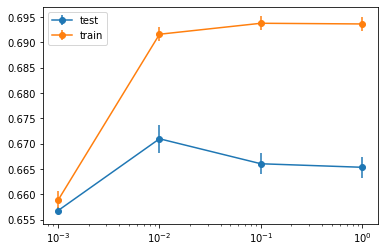

In [180]:
scores_df = pd.DataFrame(gs.cv_results_)

means_test = scores_df['mean_test_score']
error_test = scores_df['std_test_score']
cs_test = scores_df['param_model__C']
plt.errorbar(cs_test, means_test, yerr=error_test, fmt='-o', label = 'test')
plt.xscale('log')



means_train = scores_df['mean_train_score']
error_train = scores_df['std_train_score']
cs_train = scores_df['param_model__C']
plt.errorbar(cs_train, means_train, yerr=error_train, fmt='-o', label = 'train')
plt.xscale('log')

plt.legend()

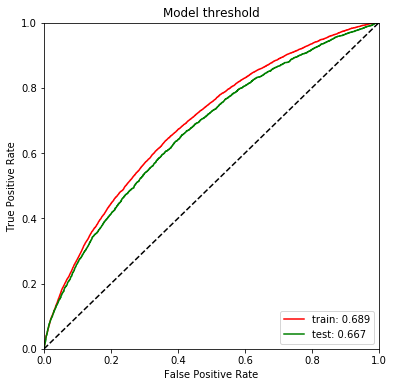

In [181]:
from sklearn import metrics

def roc_train_set(best_model, X_train, y_train, X_test, y_test):
    #best_model.fit(X_train, y_train)

    roc_auc_train_list = []
    roc_auc_test_list = []
    y_prob_train = best_model.predict_proba(X_train)
    y_prob_test = best_model.predict_proba(X_test)
    fpr_train, tpr_train, _ = metrics.roc_curve(y_train,y_prob_train[:,1])
    roc_auc_train = metrics.auc(fpr_train, tpr_train)
    roc_auc_train_list.append((fpr_train, tpr_train, roc_auc_train))
    fpr_test, tpr_test, _ = metrics.roc_curve(y_test,y_prob_test[:,1])
    roc_auc_test = metrics.auc(fpr_test, tpr_test)
    roc_auc_test_list.append((fpr_test, tpr_test, roc_auc_test))

    plt.figure(figsize=(6,6))
    colors = ["#e6194B","#3cb44b","#ffe119","#4363d8","#f58231","#911eb4","#42d4f4","#f032e6","#bfef45","#e6beff"]
    for i in range(0,1):
        if i == 0 :
            plt.plot(roc_auc_train_list[i][0], roc_auc_train_list[i][1], color = 'r', label = f'train: {round(np.average([roc_auc_train_list[i][2] for i,j in enumerate(roc_auc_train_list)]),3)}' )
            plt.plot(roc_auc_test_list[i][0], roc_auc_test_list[i][1], color = 'g', label = f'test: {round(np.average([roc_auc_test_list[i][2] for i,j in enumerate(roc_auc_test_list)]),3)}' )
        else:
            plt.plot(roc_auc_train_list[i][0], roc_auc_train_list[i][1], color = 'r')
            plt.plot(roc_auc_test_list[i][0], roc_auc_test_list[i][1], color = 'g')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Model threshold')
    plt.legend(loc='lower right')
    plt.show()
roc_train_set(best_model, X_train, y_train, X_test, y_test)

In [182]:
#below baseline
from sklearn.metrics import accuracy_score, classification_report, balanced_accuracy_score
acc = accuracy_score(y_test, preds)
acc


0.6744045368620037

In [183]:
def conf_mat_plot(confmat):

    fig, ax = plt.subplots(figsize=(5,5))
    ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax.text(x=j, y=i, s=confmat[i,j], va='center', ha='center')
    plt.xlabel('predicted label')
    plt.ylabel('true label')
    ax.xaxis.set_label_position('top')

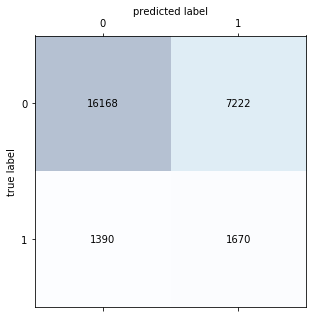

In [184]:
#lots of false positives
conf_mat_plot(metrics.confusion_matrix(y_test, preds))

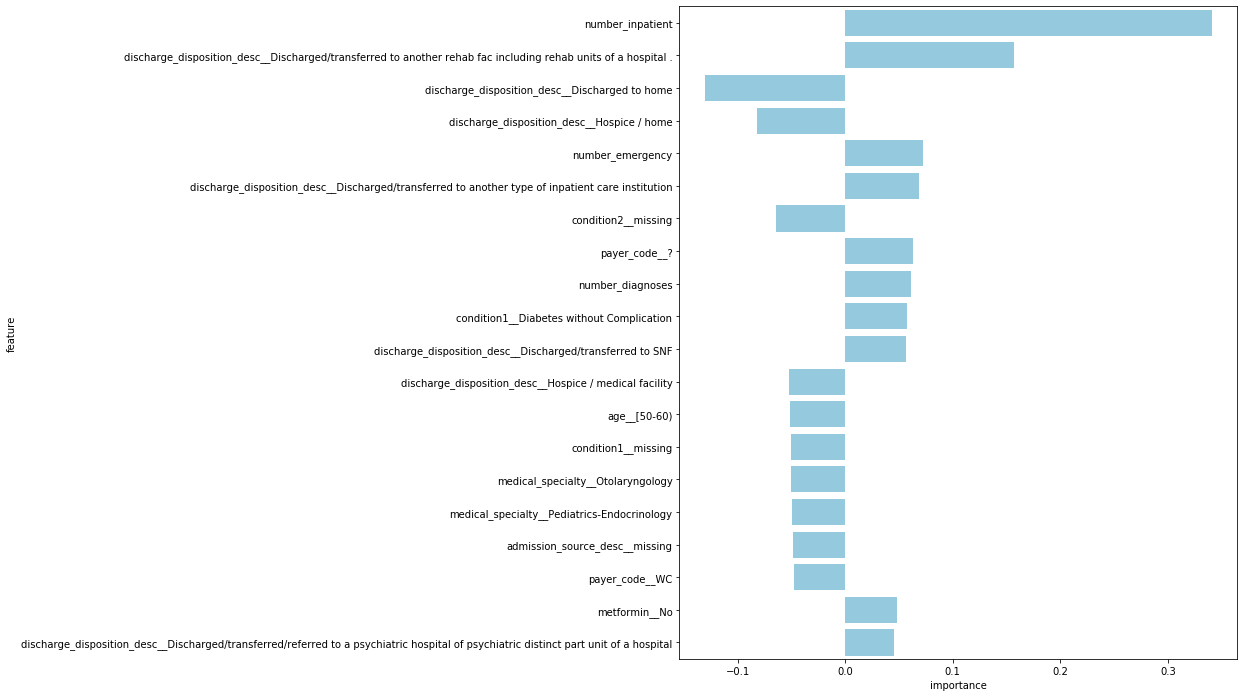

In [185]:
preprocessor = best_model.named_steps["preprocessor"]
ohe_categories = preprocessor.named_transformers_["categorical"].categories_
new_ohe_features = [f"{col}__{val}" for col, vals in zip(cat_cols, ohe_categories) for val in vals]
all_features = numeric_cols + new_ohe_features
df_importance = pd.DataFrame({'feature': all_features, 'importance' : best_model.named_steps['model'].coef_[0]})


df_importance['abs_imp'] = np.abs(df_importance['importance'])
df_importance.sort_values(['abs_imp'], ascending = 0, inplace = True)
df_importance2 = df_importance.head(20)
fig, ax = plt.subplots(figsize = (10,12))
sns.barplot(df_importance2['importance'],df_importance2['feature'], color = 'skyblue')

In [ ]:
#a lot of these make  (some don't like missing conditions...)

## next brute force random forest, all features, two classes

In [146]:
y = dfdiagdum2['target']

In [147]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X_vec,y,test_size=.40)

In [167]:

rf = RandomForestClassifier()


In [168]:
parameters = {'n_estimators': [10,100,500],'max_depth':[5,15,25],'min_samples_leaf':[10,20,50]}
#n_estimators are the number of trees bui

In [169]:
model_cv_grid = grid_search.GridSearchCV(rf,parameters,scoring='roc_auc',verbose=2,n_jobs=-1)


In [151]:
model_cv_grid.fit(X_train,y_train)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:  8.3min finished


[CV] n_estimators=10, max_depth=5, min_samples_leaf=10 ...............
[CV] n_estimators=10, max_depth=5, min_samples_leaf=10 ...............
[CV] n_estimators=10, max_depth=5, min_samples_leaf=10 ...............
[CV] n_estimators=100, max_depth=5, min_samples_leaf=10 ..............
[CV] ...... n_estimators=10, max_depth=5, min_samples_leaf=10 -   1.2s[CV] ...... n_estimators=10, max_depth=5, min_samples_leaf=10 -   1.2s[CV] ...... n_estimators=10, max_depth=5, min_samples_leaf=10 -   1.3s[CV] ..... n_estimators=100, max_depth=5, min_samples_leaf=10 -   5.8s



[CV] n_estimators=100, max_depth=5, min_samples_leaf=10 ..............[CV] n_estimators=100, max_depth=5, min_samples_leaf=10 ..............[CV] n_estimators=500, max_depth=5, min_samples_leaf=10 ..............
[CV] n_estimators=500, max_depth=5, min_samples_leaf=10 ..............


[CV] ..... n_estimators=500, max_depth=5, min_samples_leaf=10 -  26.7s[CV] ..... n_estimators=500, max_depth=5, min_samples_leaf=10 -  26.3s[CV] ...

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [10, 100, 500], 'max_depth': [5, 15, 25], 'min_samples_leaf': [10, 20, 50]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=2)





[CV] n_estimators=100, max_depth=25, min_samples_leaf=50 .............
[CV] .... n_estimators=500, max_depth=25, min_samples_leaf=20 - 1.5min[CV] n_estimators=500, max_depth=25, min_samples_leaf=50 .............
[CV] .... n_estimators=100, max_depth=25, min_samples_leaf=50 -  14.5s
[CV] .... n_estimators=500, max_depth=25, min_samples_leaf=50 - 1.0min

[CV] n_estimators=100, max_depth=25, min_samples_leaf=50 .............
[CV] .... n_estimators=100, max_depth=25, min_samples_leaf=50 -  15.0s
[CV] n_estimators=500, max_depth=25, min_samples_leaf=50 .............
[CV] .... n_estimators=500, max_depth=25, min_samples_leaf=50 - 1.0min


In [152]:
best_model = model_cv_grid.best_estimator_

In [153]:
best_model

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=25, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=50,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [154]:
best_model.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=25, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=50,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

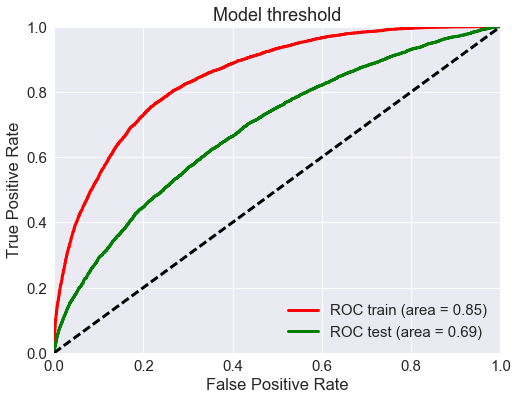

In [52]:
y_prob_train = best_model.predict_proba(X_train)
y_prob_test = best_model.predict_proba(X_test)

fpr_train, tpr_train, _ = metrics.roc_curve(y_train,y_prob_train[:,1])
roc_auc_train = metrics.auc(fpr_train, tpr_train)

fpr_test, tpr_test, _ = metrics.roc_curve(y_test, y_prob_test[:,1])
roc_auc_test = metrics.auc(fpr_test, tpr_test)

plt.figure(figsize=(8,6))
plt.plot(fpr_train, tpr_train, color = 'r')
plt.plot(fpr_test, tpr_test, color = 'g')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Model threshold')
green_line = mlines.Line2D([], [], color='green', label='ROC test (area = %0.2f)' % np.mean(roc_auc_test))
red_line = mlines.Line2D([], [], color='red', label='ROC train (area = %0.2f)' % roc_auc_train)
plt.legend(handles=[red_line, green_line],loc="lower right")
plt.savefig('roc_first_rf_two_class.png', dpi = 300)

## my model is only predicting one class!! just the not readmited class

[[38138     0]
 [ 4902     0]]


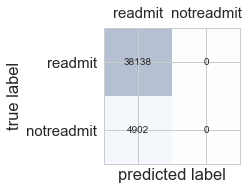

In [57]:
predictions=best_model.predict(X_test)

labels = ['readmit', 'notreadmit'] #these are backwards
cm = metrics.confusion_matrix(y_test, predictions)
print(cm)
fig, ax = plt.subplots(figsize=(2.5,2.5))
ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i, s=cm[i,j], va='center', ha='center')
plt.xlabel('predicted label')
plt.ylabel('true label')
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.show()
plt.savefig('randomforest_two_class_cm.png', dpi = 300)

In [54]:

y_prob = best_model.predict_proba(X_vec)

dfdiagdum2['score'] = y_prob[:,1]

In [55]:
dfdiagdum2.sort(['score'], ascending = 0).tail()

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,encounter_id,patient_nbr,race,gender,age,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,max_glu_serum,A1Cresult,metformin,glimepiride,glipizide,glyburide,pioglitazone,rosiglitazone,insulin,change,diabetesMed,readmitted,admission_type_desc,discharge_disposition_desc,admission_source_desc,cleaned_age,target,Acute Myocardial Infarction,Acute Renal Failure,"Amputation Status, Lower Limb/Amputation Complications",Amyotrophic Lateral Sclerosis and Other Motor Neuron Disease,Angina Pectoris,Artificial Openings for Feeding or Elimination,Aspiration and Specified Bacterial Pneumonias,Atherosclerosis of the Extremities with Ulceration or Gangrene,Bone/Joint/Muscle Infections/Necrosis,"Breast, Prostate, and Other Cancers and Tumors",Cardio-Respiratory Failure and Shock,Cerebral Hemorrhage,Cerebral Palsy,Chronic Hepatitis,"Chronic Kidney Disease, Stage 5",Chronic Obstructive Pulmonary Disease,Chronic Pancreatitis,"Chronic Ulcer of Skin, Except Pressure",...,Complications of Specified Implanted Device or Graft,Congestive Heart Failure,Diabetes with Chronic Complications,Diabetes without Complication,Dialysis Status,Disorders of Immunity,Drug/Alcohol Dependence,Drug/Alcohol Psychosis,End-Stage Liver Disease,Fibrosis of Lung and Other Chronic Lung Disorders,HIV/AIDS,Hemiplegia/Hemiparesis,Hip Fracture/Dislocation,Inflammatory Bowel Disease,Intestinal Obstruction/Perforation,Ischemic or Unspecified Stroke,Lung and Other Severe Cancers,Lymphoma and Other Cancers,"Major Depressive, Bipolar, and Paranoid Disorders",Major Head Injury,Major Organ Transplant or Replacement Status,Metastatic Cancer and Acute Leukemia,"Monoplegia, Other Paralytic Syndromes",Morbid Obesity,Multiple Sclerosis,Muscular Dystrophy,"Myasthenia Gravis/Myoneural Disorders, Inflammatory and Toxic Neuropathy",Opportunistic Infections,Other Significant Endocrine and Metabolic Disorders,Parkinson's and Huntington's Diseases,"Pneumococcal Pneumonia, Empyema, Lung Abscess",Proliferative Diabetic Retinopathy and Vitreous Hemorrhage,Protein-Calorie Malnutrition,Respirator Dependence/Tracheostomy Status,Respiratory Arrest,Rheumatoid Arthritis and Inflammatory Connective Tissue Disease,Schizophrenia,Seizure Disorders and Convulsions,"Septicemia, Sepsis, Systemic Inflammatory Response Syndrome/Shock",Severe Hematological Disorders,Severe Skin Burn or Condition,Specified Heart Arrhythmias,Spinal Cord Disorders/Injuries,Traumatic Amputations and Complications,Unstable Angina and Other Acute Ischemic Heart Disease,Vascular Disease,Vascular Disease with Complications,Vertebral Fractures without Spinal Cord Injury,target2,score
42266,124624812,24016869,Caucasian,Female,[60-70),2,MC,Surgery-Cardiovascular/Thoracic,51,2,32,0,0,0,9,None,None,0,0,0,0,0,0,1,No,Yes,NO,Emergency,Expired,Emergency Room,6,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.019320
62845,167569692,28945719,AfricanAmerican,Female,[50-60),3,none,none,58,3,27,0,0,0,9,None,None,0,0,0,0,0,0,1,No,Yes,NO,Emergency,Expired,Clinic Referral,5,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.019209
102729,384946310,97719030,Caucasian,Male,[50-60),1,MC,none,80,3,20,0,0,0,12,None,None,0,0,0,0,0,0,1,No,Yes,NO,Emergency,Expired,Emergency Room,5,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0

## intiutively the features that are most important make sense, especially the number of inpatient visits in the year preceding the encounter

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


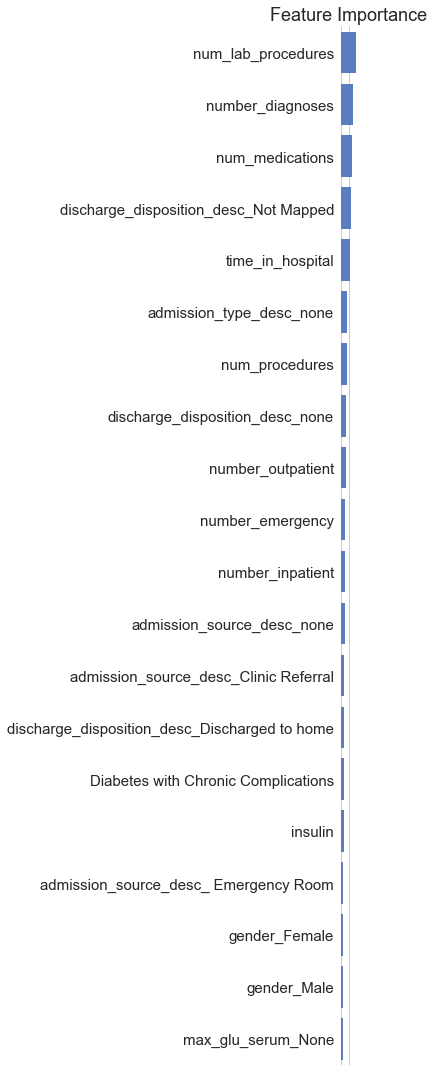

In [155]:
df_importance = pd.DataFrame({'feature': X_train.columns, 'importance' : best_model.feature_importances_})




result = df_importance.sort(['importance'], ascending=False).reset_index()


resultshort = result[:20]

y1= resultshort['feature'][0:]
x1 = resultshort['importance'][0:]

sns.set(style="whitegrid",font_scale=1.5)
f, ax = plt.subplots(figsize=(6, 15))
fig = plt.gcf()
plt.tight_layout()
sns.set_color_codes("muted")
sns.barplot(x=x1, y=y1, color="b")
ax.set(xticklabels=[],ylabel='',xlabel='',title='Feature Importance')
sns.despine(left=True, bottom=True)
fig.savefig('randomforest_twoclass_feature_importance.png', dpi=300,bbox_inches='tight')

In [58]:
result.tail() #many features appear not to be important

,index,feature,importance
152,132,discharge_disposition_desc_Expired in a medica...,0.0
153,131,discharge_disposition_desc_Expired at home. Me...,0.0
154,114,discharge_disposition_desc_Admitted as an inpa...,0.0
155,22,Atherosclerosis of the Extremities with Ulcera...,0.0
156,129,discharge_disposition_desc_Discharged/transfer...,0.0


In [59]:
predictions=best_model.predict(X_test)
sklearn.metrics.accuracy_score(y_test, predictions)


0.88610594795539033

## model is not detecting any readmitted class!!! and of course it has high precision and recall for the other class because it just labels all as class 0!

In [60]:
print "----confusion matrix----"
print metrics.confusion_matrix(y_test, predictions)
print 
print "----classification report----"
print metrics.classification_report(y_test, predictions)  

----confusion matrix----
[[38138     0]
 [ 4902     0]]

----classification report----
             precision    recall  f1-score   support

          0       0.89      1.00      0.94     38138
          1       0.00      0.00      0.00      4902

avg / total       0.79      0.89      0.83     43040



/usr/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## this is not predicting my readmitted class!!!

In [61]:
y_prob_test = best_model.predict_proba(X_test)
precision_val, recall_val, thresholds_val = metrics.precision_recall_curve(y_test,y_prob_test[:,1])

In [62]:
thresholds_val = np.append(thresholds_val, 1)
queue_rate_val = []  
for threshold in thresholds_val:  
    queue_rate_val.append((y_prob_test[:,1] >= threshold).mean())

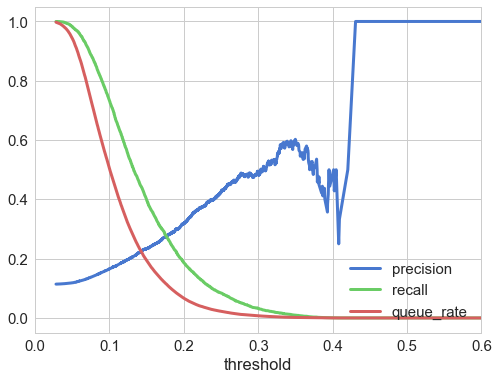

In [63]:

plt.figure(figsize=(8,6))
plt.plot(thresholds_val, precision_val, color = 'b', linewidth=3.0)  
plt.plot(thresholds_val, recall_val, color = 'g', linewidth=3.0)  
plt.plot(thresholds_val, queue_rate_val, color = 'r', linewidth=3.0)
leg = plt.legend(('precision', 'recall', 'queue_rate'),loc="lower right")
plt.xlabel('threshold')
plt.xlim([0.0, 0.6])
# at a certain threshold this does terribly, perhaps because it is acurately predicting the not readmitted class but then fails
#completely for all readmitted
plt.savefig('rf_two_class_precision_recall.png', dpi = 300)

In [64]:
dfdiagdum2['predictions'] = best_model.predict(X_vec)

In [65]:
dfdiagdum2.predictions.unique() #looks like it's only predicting one class!!!!!

array([0])

## This looks very bad...seems like my model is only predicting one class ? :( try two things, predicting on three classes and make classes of readmitted and not more equal for training purposes

In [407]:
#try with three classes
len(dfdiagdum2[dfdiagdum2['target2']==1]), len(dfdiagdum2[dfdiagdum2['target2']==0]), len(dfdiagdum2[dfdiagdum2['target2']==2])

(12133, 57921, 37546)

In [26]:
from sklearn.datasets import make_classification
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle #having trouble importing the multioutputclassifier module

In [27]:
from sklearn import svm
#traditionally handles multi class but takes standardized inputs

## here taking equal subsample of two classes

In [133]:
#i want to use svm.svc but i am having trouble importing the library
#try a subsample of the three classes that has equal proportions
#randomly sampe 5000 from each class

num = 5000 #number of samples
sub_ind_readmit = random.sample(list(dfdiagdum2[dfdiagdum2['readmitted']=='<30'].index),num)
sub_ind_notreadmit = random.sample(list(dfdiagdum2[dfdiagdum2['readmitted'].isin(['NO','>30'])].index),num)

In [134]:
subindex = []
for i in sub_ind_readmit:
    subindex.append(i)
for i in sub_ind_notreadmit:
    subindex.append(i)

In [135]:
len(set(subindex))

10000

In [136]:
#use a subset of the data to train because it takes a while, take a sample of 10000

X_vec_10k = X_vec.loc[subindex]
y = dfdiagdum2['target']
y_10k = y.loc[subindex]

In [137]:
#split into test train and  standardize
from sklearn.preprocessing import StandardScaler
stdsc = StandardScaler()
X_train_10k, X_test_10k, y_train_10k, y_test_10k = cross_validation.train_test_split(X_vec_10k,y_10k)
X_train_norm = stdsc.fit_transform(X_train_10k)
X_test_norm = stdsc.transform(X_test_10k)

## redo and train and test on subset of the data equally represeting both classes

In [138]:
X_train_10k, X_test_10k, y_train_10k, y_test_10k = cross_validation.train_test_split(X_vec_10k,y_10k)

In [139]:

rf = RandomForestClassifier()
parameters = {'n_estimators': [10,100,500],'max_depth':[5,15,25],'min_samples_leaf':[10,20,50]}
model_cv_grid = grid_search.GridSearchCV(rf,parameters,scoring='roc_auc',verbose=2,n_jobs=-1)
model_cv_grid.fit(X_train_10k,y_train_10k)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   21.2s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:  1.1min finished


[CV] n_estimators=10, max_depth=5, min_samples_leaf=10 ...............
[CV] n_estimators=10, max_depth=5, min_samples_leaf=10 ...............
[CV] n_estimators=10, max_depth=5, min_samples_leaf=10 ...............
[CV] n_estimators=100, max_depth=5, min_samples_leaf=10 ..............
[CV] ...... n_estimators=10, max_depth=5, min_samples_leaf=10 -   0.2s[CV] ...... n_estimators=10, max_depth=5, min_samples_leaf=10 -   0.2s[CV] ...... n_estimators=10, max_depth=5, min_samples_leaf=10 -   0.2s[CV] ..... n_estimators=100, max_depth=5, min_samples_leaf=10 -   1.2s



[CV] n_estimators=100, max_depth=5, min_samples_leaf=10 ..............
[CV] n_estimators=100, max_depth=5, min_samples_leaf=10 ..............
[CV] n_estimators=500, max_depth=5, min_samples_leaf=10 ..............
[CV] n_estimators=500, max_depth=5, min_samples_leaf=10 ..............
[CV] ..... n_estimators=100, max_depth=5, min_samples_leaf=10 -   1.2s[CV] ..... n_estimators=100, max_depth=5, min_samples_leaf=10 -   1.2s[CV] ...

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [10, 100, 500], 'max_depth': [5, 15, 25], 'min_samples_leaf': [10, 20, 50]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=2)

In [140]:
best_model = model_cv_grid.best_estimator_

In [141]:

best_model

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=15, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=10,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [142]:
best_model.fit(X_train_10k,y_train_10k)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=15, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=10,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [143]:
#what if we use the model on the full training dataset?
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X_vec,y,test_size=.40)
best_model.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=15, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=10,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

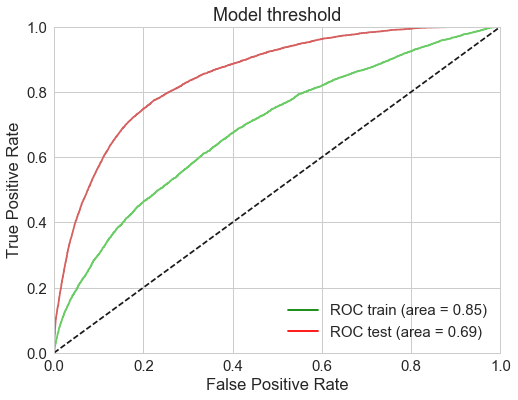

In [77]:
y_prob_train_tuned = best_model.predict_proba(X_train)
y_prob_test_tuned = best_model.predict_proba(X_test)
fpr_train_tuned, tpr_train_tuned, _ = metrics.roc_curve(y_train,y_prob_train_tuned[:,1])
roc_auc_train_tuned = metrics.auc(fpr_train_tuned, tpr_train_tuned)
fpr_test_tuned, tpr_test_tuned, _ = metrics.roc_curve(y_test,y_prob_test_tuned[:,1])
roc_auc_test_tuned = metrics.auc(fpr_test_tuned, tpr_test_tuned)
plt.figure(figsize=(8,6))
plt.plot(fpr_train_tuned, tpr_train_tuned, color = 'r')
plt.plot(fpr_test_tuned, tpr_test_tuned, color = 'g')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Model threshold')
green_line = mlines.Line2D([], [], color='green', label='ROC train (area = %0.2f)' % np.mean(roc_auc_train_tuned))
red_line = mlines.Line2D([], [], color='red', label='ROC test (area = %0.2f)' % roc_auc_test_tuned)
plt.legend(handles=[green_line, red_line],loc="lower right")
plt.savefig('roc_rf_equal_two_class.png', dpi = 300)

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


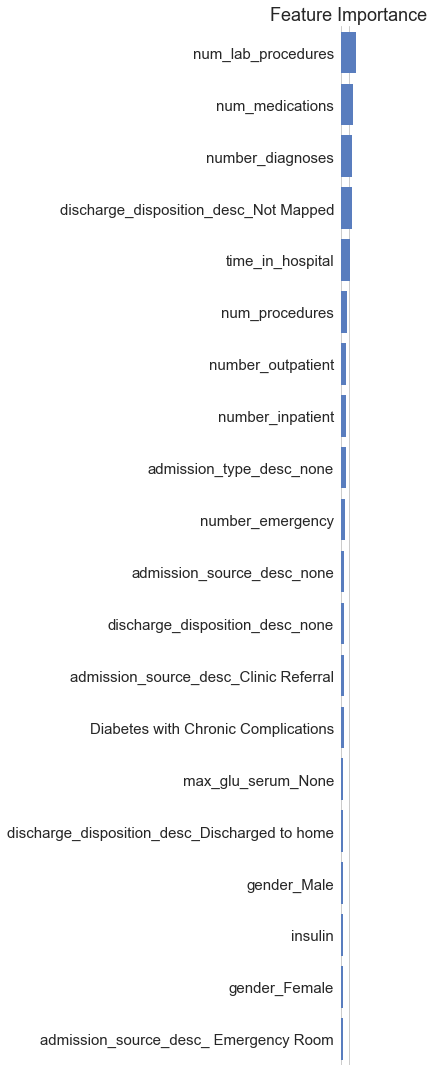

In [144]:
df_importance = pd.DataFrame({'feature': X_train.columns, 'importance' : best_model.feature_importances_})




result = df_importance.sort(['importance'], ascending=False).reset_index()


resultshort = result[:20]

y1= resultshort['feature'][0:]
x1 = resultshort['importance'][0:]

sns.set(style="whitegrid",font_scale=1.5)
f, ax = plt.subplots(figsize=(6, 15))
fig = plt.gcf()
plt.tight_layout()
sns.set_color_codes("muted")
sns.barplot(x=x1, y=y1, color="b")
ax.set(xticklabels=[],ylabel='',xlabel='',title='Feature Importance')
sns.despine(left=True, bottom=True)
fig.savefig('randomforest_twoclass_feature_importance_equalclass.png', dpi=300,bbox_inches='tight')

In [78]:
#looks like it does so, so, does it predict two classes???
dfdiagdum2['predictions2'] = best_model.predict(X_vec)

In [79]:
dfdiagdum2.predictions2.unique() #NOOOOO WHY?

array([0])

In [81]:
predictions=best_model.predict(X_test_10k)
print "----confusion matrix----"
print metrics.confusion_matrix(y_test_10k, predictions)
print 
print "----classification report----"
print metrics.classification_report(y_test_10k, predictions)  

----confusion matrix----
[[1288    0]
 [1212    0]]

----classification report----
             precision    recall  f1-score   support

          0       0.52      1.00      0.68      1288
          1       0.00      0.00      0.00      1212

avg / total       0.27      0.52      0.35      2500



In [82]:
y_prob = best_model.predict_proba(X_vec)

dfdiagdum2['score2'] = y_prob[:,1]

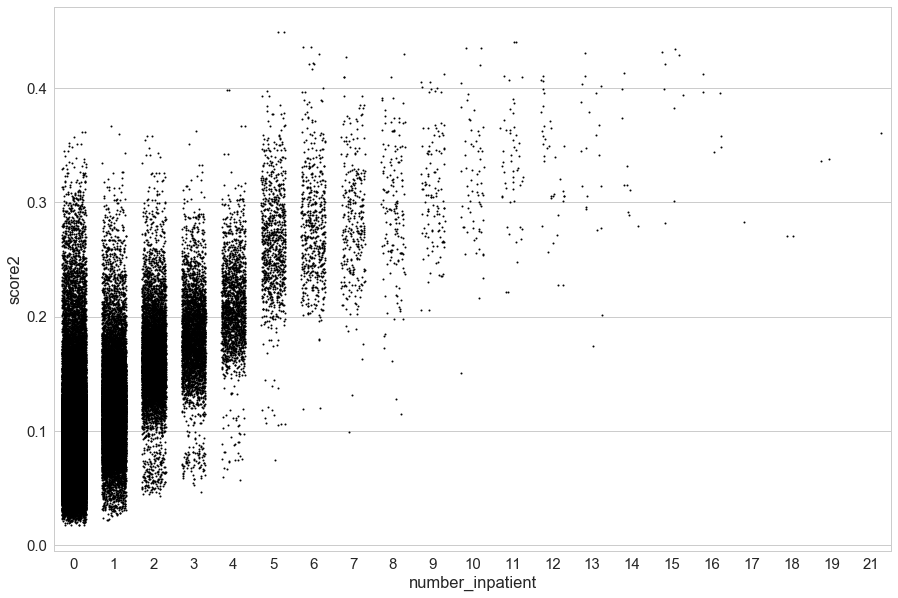

In [83]:

plt.figure(figsize=(15, 10))


sns.stripplot(x="number_inpatient", y="score2"
                    ,data=dfdiagdum2.sort_values(by="number_inpatient")
                    ,orient='v',jitter=0.3, size=1
                    , color="0.1",edgecolor="black")
plt.savefig('rf_score_number_inpatient.png', dpi = 300)

## there is a major issue with the random forest. it is only predicting one class, the non-readmitted class.  THREE CLASS RANDOM FOREST

In [201]:
#multi class random forest
from sklearn.preprocessing import MultiLabelBinarizer


In [202]:
num = 5000 #number of samples  per category
sub_ind_readmit = random.sample(list(dfdiagdum2[dfdiagdum2['readmitted']=='<30'].index),num)
sub_ind_notreadmit = random.sample(list(dfdiagdum2[dfdiagdum2['readmitted']=='NO'].index),num)
sub_ind_over30 = random.sample(list(dfdiagdum2[dfdiagdum2['readmitted']=='>30'].index),num)


In [203]:
subindex = []
for i in sub_ind_readmit:
    subindex.append(i)
for i in sub_ind_notreadmit:
    subindex.append(i)
for i in sub_ind_over30:
    subindex.append(i)

In [204]:
X_vec_10k = X_vec.loc[subindex]
y = dfdiagdum2['target2']
y_10k = y.loc[subindex]

In [219]:
targetlist = dfdiagdum2['target2'].loc[subindex].tolist()

In [228]:
targetstring = []
for i in dfdiagdum2['target2'].loc[subindex]:
    i = str(i)
    targetstring.append(i)

In [230]:
ymulti = MultiLabelBinarizer().fit_transform(targetstring)

In [231]:
n_samples, n_features = X_vec_10k.shape 
n_outputs = ymulti.shape[1] 
n_classes = 3

In [233]:
forest = RandomForestClassifier(n_estimators=100, random_state=1)

In [234]:
multi_target_forest = MultiOutputClassifier(forest, n_jobs=-1)

In [235]:
multi_target_forest.fit(X_vec_10k,ymulti)

MultiOutputClassifier(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=1,
            verbose=0, warm_start=False),
           n_jobs=-1)

In [237]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X_vec_10k,ymulti,test_size=.40)


In [238]:
multi_target_forest.fit(X_train,y_train)

MultiOutputClassifier(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=1,
            verbose=0, warm_start=False),
           n_jobs=-1)

In [242]:
predictions=multi_target_forest.predict(X_test)
print "----confusion matrix----"
print metrics.confusion_matrix(y_test, predictions)
print 
print "----classification report----"
print metrics.classification_report(y_test, predictions) 

----confusion matrix----


ValueError: multilabel-indicator is not supported

In [243]:
multi_target_forest.predict(X_vec)

array([[0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       ..., 
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0]])

In [244]:
#try regular random forest
rf = RandomForestClassifier()
parameters = {'n_estimators': [10,100,500],'max_depth':[5,15,25],'min_samples_leaf':[10,20,50]}
model_cv_grid = grid_search.GridSearchCV(rf,parameters,scoring='roc_auc',verbose=2,n_jobs=-1)
model_cv_grid.fit(X_train, y_train)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   19.1s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:  1.1min finished


[CV] n_estimators=10, max_depth=5, min_samples_leaf=10 ...............
[CV] n_estimators=10, max_depth=5, min_samples_leaf=10 ...............
[CV] n_estimators=10, max_depth=5, min_samples_leaf=10 ...............
[CV] n_estimators=100, max_depth=5, min_samples_leaf=10 ..............
[CV] ...... n_estimators=10, max_depth=5, min_samples_leaf=10 -   0.3s[CV] ...... n_estimators=10, max_depth=5, min_samples_leaf=10 -   0.3s[CV] ...... n_estimators=10, max_depth=5, min_samples_leaf=10 -   0.2s[CV] ..... n_estimators=100, max_depth=5, min_samples_leaf=10 -   1.4s



[CV] n_estimators=100, max_depth=5, min_samples_leaf=10 ..............
[CV] n_estimators=100, max_depth=5, min_samples_leaf=10 ..............
[CV] n_estimators=500, max_depth=5, min_samples_leaf=10 ..............
[CV] n_estimators=500, max_depth=5, min_samples_leaf=10 ..............
[CV] ..... n_estimators=100, max_depth=5, min_samples_leaf=10 -   1.2s[CV] ..... n_estimators=100, max_depth=5, min_samples_leaf=10 -   1.2s[CV] ...

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [10, 100, 500], 'max_depth': [5, 15, 25], 'min_samples_leaf': [10, 20, 50]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=2)

In [245]:
best_model = model_cv_grid.best_estimator_
best_model.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=25, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=10,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


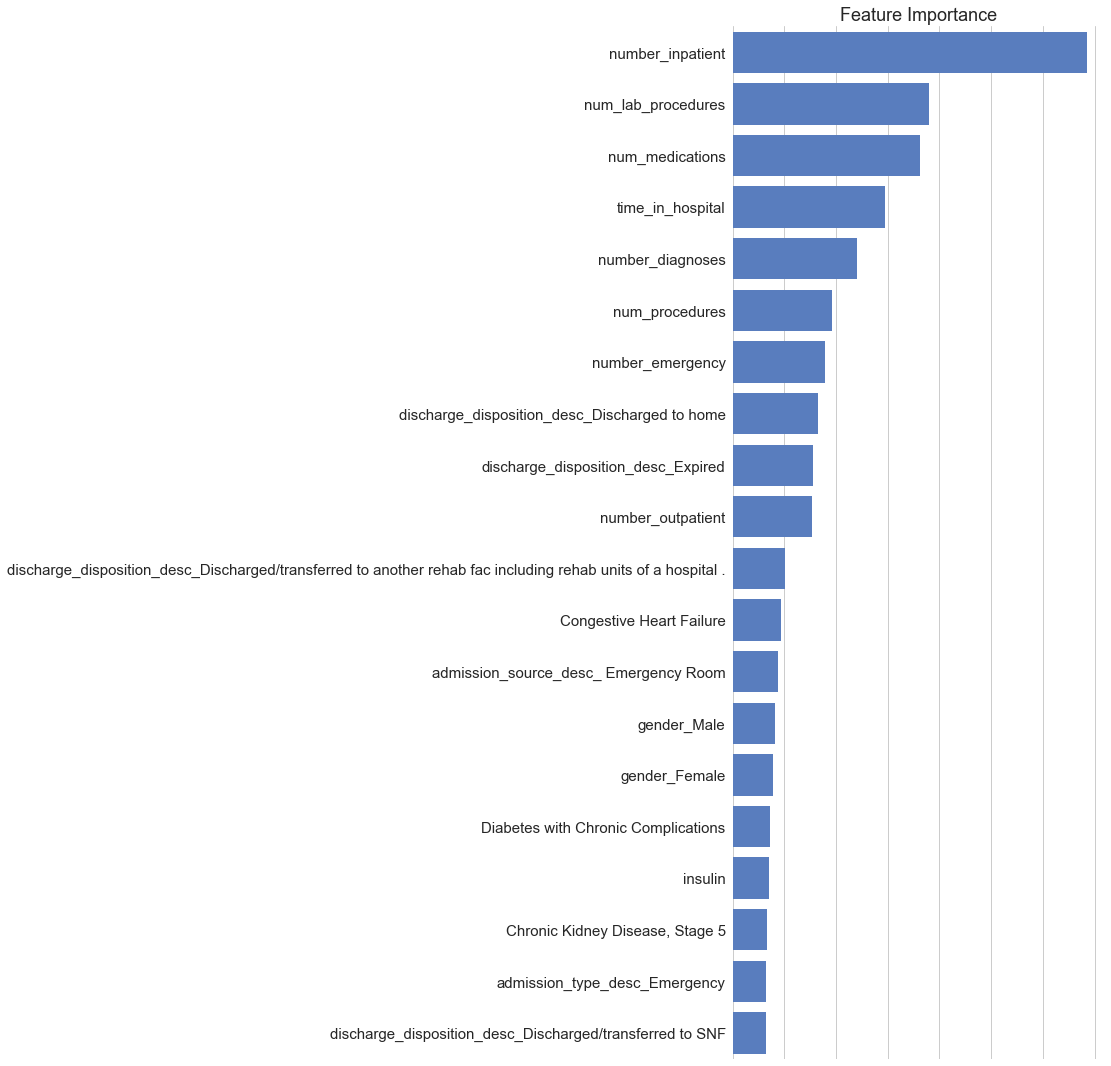

In [247]:
df_importance = pd.DataFrame({'feature': X_train.columns, 'importance' : best_model.feature_importances_})




result = df_importance.sort(['importance'], ascending=False).reset_index()


resultshort = result[:20]

y1= resultshort['feature'][0:]
x1 = resultshort['importance'][0:]

sns.set(style="whitegrid",font_scale=1.5)
f, ax = plt.subplots(figsize=(6, 15))
fig = plt.gcf()
plt.tight_layout()
sns.set_color_codes("muted")
sns.barplot(x=x1, y=y1, color="b")
ax.set(xticklabels=[],ylabel='',xlabel='',title='Feature Importance')
sns.despine(left=True, bottom=True)
fig.savefig('randomforest_threeclass_feature_importance_equalclass.png', dpi=300,bbox_inches='tight')

In [255]:
multipred = best_model.predict(X_vec)

In [256]:
dftarget = pd.DataFrame(multipred)

In [265]:
dftarget.columns = [['NO','under_30','over_30']] #0 is no, 1 is <30, 2 is >30

In [266]:
dftarget['NO'].unique() #order was lost so can not rejoin back to original

array([ 0.,  1.])

## redo and try with logistic regression. this means do standard scaling.


## can try a few things. first just train/testing on my original split data. can also train/test on the subset of data with equal classes. also i am scaling everything but should perhaps try only scaling the numeric and joining back to the dummy variable columns

In [84]:
from sklearn.preprocessing import StandardScaler
stdsc = StandardScaler()

X_train_norm = stdsc.fit_transform(X_train_10k)
X_test_norm = stdsc.transform(X_test_10k)


In [85]:
from sklearn import svm, metrics, grid_search, linear_model, datasets
from sklearn.linear_model import LogisticRegression
cls = linear_model.LogisticRegression()


In [86]:
#the grid search automatically includes l1 and l2 and it will find the best one!
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] }
gslr = grid_search.GridSearchCV(cls, 
                                param_grid= {'penalty': ['l1','l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
                               ).fit(X_train_norm, y_train_10k)

In [87]:
print 'Best score:', gslr.best_score_ 
print 'Best estimator:', gslr.best_estimator_

Best score: 0.61
Best estimator: LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


In [88]:
gslr_best = gslr.best_estimator_

In [114]:
gslr_best.fit(X_train_10k,y_train_10k)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [115]:
x_pred_test = gslr_best.predict(X_test_norm)
print "----confusion matrix----"
print metrics.confusion_matrix(y_test_10k, x_pred_test)
print 
print "----classification report----"
print metrics.classification_report(y_test_10k, x_pred_test) 

----confusion matrix----
[[946 342]
 [717 495]]

----classification report----
             precision    recall  f1-score   support

          0       0.57      0.73      0.64      1288
          1       0.59      0.41      0.48      1212

avg / total       0.58      0.58      0.56      2500



[[946 342]
 [717 495]]


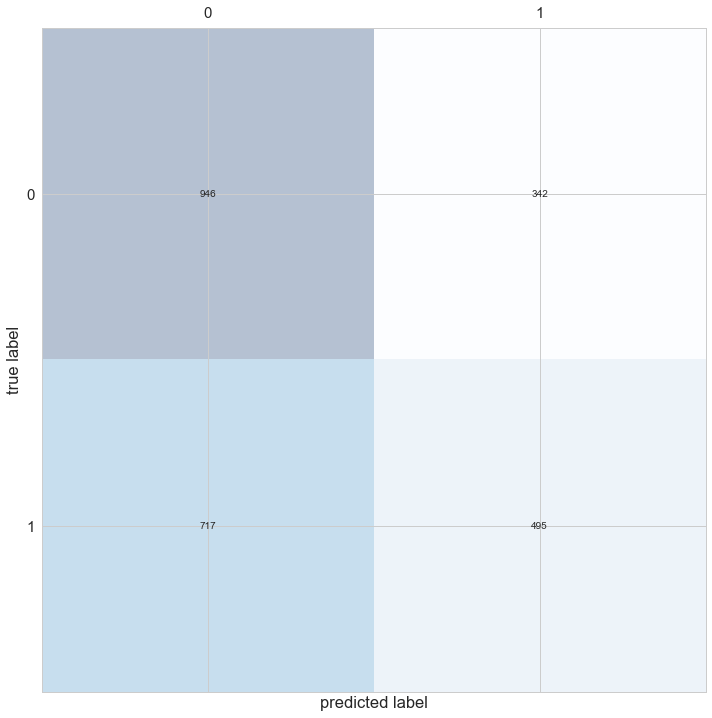

In [116]:
labels = [0,1]
cm = metrics.confusion_matrix(y_test_10k, x_pred_test)
print(cm)
fig, ax = plt.subplots(figsize=(10,20))
ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i, s=cm[i,j], va='center', ha='center')
plt.xlabel('predicted label')
plt.ylabel('true label')
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.show() #does butter than chance but not great
plt.savefig('logistic_regression_cm_twoclass.png', dpi = 300)

In [92]:
y_prob_train = gslr_best.predict_proba(X_train_norm)
y_prob_test = gslr_best.predict_proba(X_test_norm)
fpr_train, tpr_train, _ = metrics.roc_curve(y_train_10k,y_prob_train[:,1])
roc_auc_train = metrics.auc(fpr_train, tpr_train)
fpr_test, tpr_test, _ = metrics.roc_curve(y_test_10k, y_prob_test[:,1])
roc_auc_test = metrics.auc(fpr_test, tpr_test)


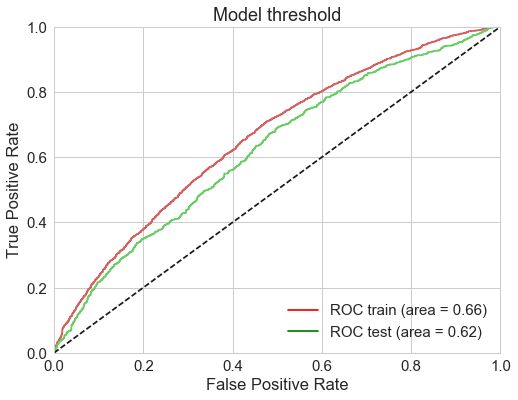

In [93]:
plt.figure(figsize=(8,6))
plt.plot(fpr_train, tpr_train, color = 'r')
plt.plot(fpr_test, tpr_test, color = 'g')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Model threshold')
green_line = mlines.Line2D([], [], color='green', label='ROC test (area = %0.2f)' % np.mean(roc_auc_test))

red_line = mlines.Line2D([], [], color='red', label='ROC train (area = %0.2f)' % roc_auc_train)
plt.legend(handles=[red_line, green_line],loc="lower right")
plt.savefig('roc_lg_twoclass.png', dpi = 300)

In [159]:
#look at feature importance

df_importance = pd.DataFrame({'variable': X_vec.columns, 'importance' : gslr_best.coef_[0]})
result = df_importance.sort(['importance'], ascending=False).reset_index()
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

resultshort = result[:20]
y1= resultshort['variable'][0:]
x1 = resultshort['importance'][0:]
sns.set(style="whitegrid",font_scale=1.5)
f, ax = plt.subplots(figsize=(6, 15))
fig = plt.gcf()

sns.set_color_codes("muted")
sns.barplot(x=x1, y=y1, color="b")
ax.set(xticklabels=[],ylabel='',xlabel='',title='Feature Importance')
sns.despine(left=True, bottom=True)
plt.savefig('lg_feature_importance_twoclass.png', dpi = 300, box = )

SyntaxError: invalid syntax (<ipython-input-159-220d0b00e067>, line 19)

In [95]:
#how about on the full training data?

X_train_norm_full = stdsc.fit_transform(X_train)
X_test_norm_full = stdsc.transform(X_test)


In [96]:
gslr_best.fit(X_train_norm_full,y_train)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [97]:
y_prob_train_tuned = gslr_best.predict_proba(X_train_norm_full)
y_prob_test_tuned = gslr_best.predict_proba(X_test_norm_full)


In [98]:
fpr_train_tuned, tpr_train_tuned, _ = metrics.roc_curve(y_train,y_prob_train_tuned[:,1])
roc_auc_train_tuned = metrics.auc(fpr_train_tuned, tpr_train_tuned)
fpr_test_tuned, tpr_test_tuned, _ = metrics.roc_curve(y_test,y_prob_test_tuned[:,1])
roc_auc_test_tuned = metrics.auc(fpr_test_tuned, tpr_test_tuned)

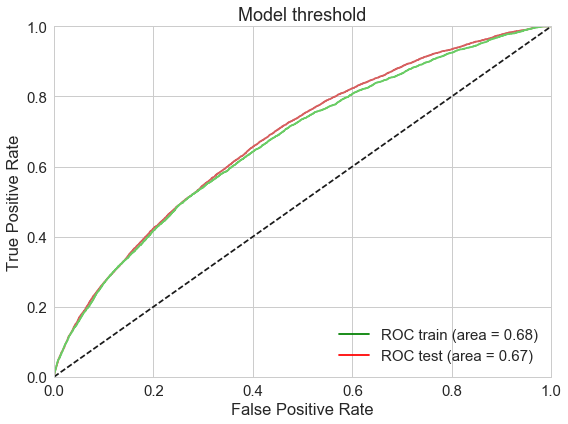

In [99]:
plt.figure(figsize=(8,6))
plt.plot(fpr_train_tuned, tpr_train_tuned, color = 'r')
plt.plot(fpr_test_tuned, tpr_test_tuned, color = 'g')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Model threshold')
green_line = mlines.Line2D([], [], color='green', label='ROC train (area = %0.2f)' % np.mean(roc_auc_train_tuned))
red_line = mlines.Line2D([], [], color='red', label='ROC test (area = %0.2f)' % roc_auc_test_tuned)
plt.legend(handles=[green_line, red_line],loc="lower right")
plt.savefig('lg_roc_fulldata_twoclass.png', dpi = 300)

In [160]:
#look at feature importance

df_importance = pd.DataFrame({'variable': X_vec.columns, 'importance' : gslr_best.coef_[0]})

In [161]:
result = df_importance.sort(['importance'], ascending=False).reset_index()


resultshort = result[:20]

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


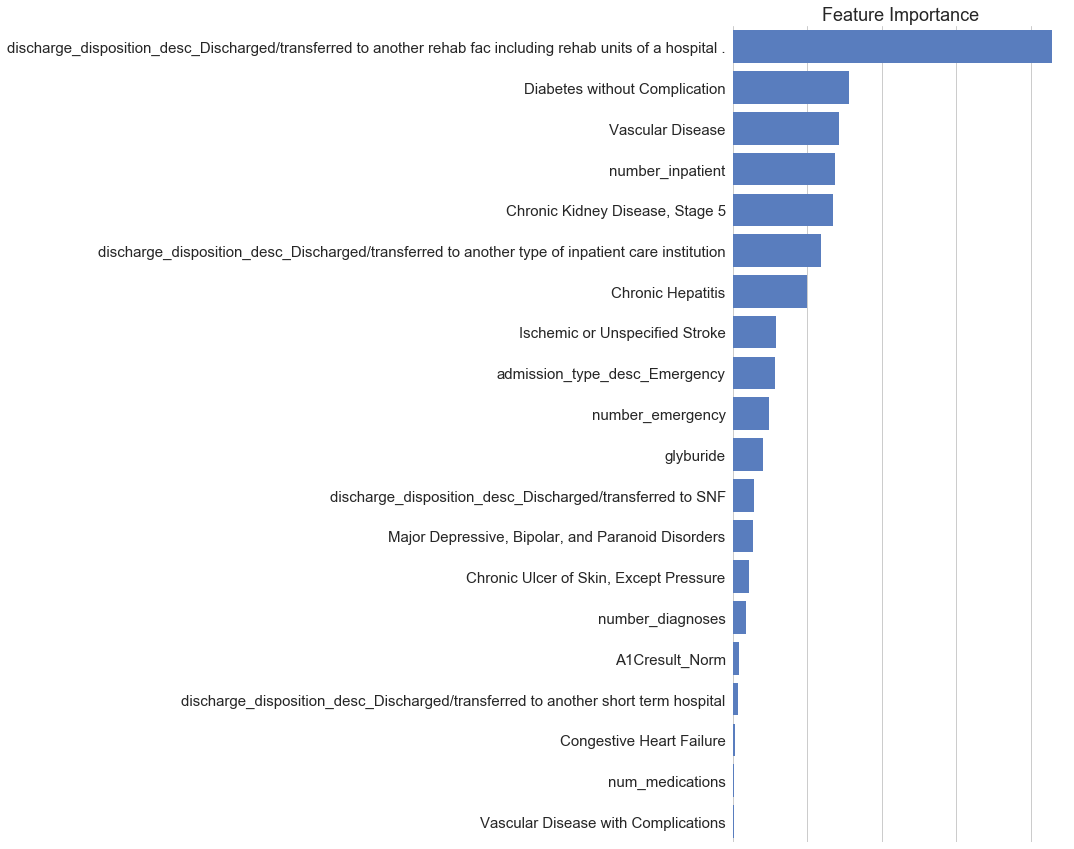

In [162]:
y1= resultshort['variable'][0:]
x1 = resultshort['importance'][0:]
sns.set(style="whitegrid",font_scale=1.5)
f, ax = plt.subplots(figsize=(6, 15))
fig = plt.gcf()
sns.set_color_codes("muted")
sns.barplot(x=x1, y=y1, color="b")
ax.set(xticklabels=[],ylabel='',xlabel='',title='Feature Importance')
sns.despine(left=True, bottom=True)


fig.savefig('lg_twoclass_feature_importance_fulldata.png', dpi=300,bbox_inches='tight')

In [103]:
x_pred_test = gslr_best.predict(X_test_norm_full)
print "----confusion matrix----"
print metrics.confusion_matrix(y_test, x_pred_test)
print 
print "----classification report----"
print metrics.classification_report(y_test, x_pred_test) 

----confusion matrix----
[[38044    93]
 [ 4811    92]]

----classification report----
             precision    recall  f1-score   support

          0       0.89      1.00      0.94     38137
          1       0.50      0.02      0.04      4903

avg / total       0.84      0.89      0.84     43040



[[38044    93]
 [ 4811    92]]


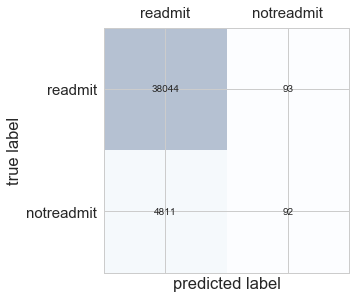

In [104]:
labels = ['readmit', 'notreadmit']
cm = metrics.confusion_matrix(y_test, x_pred_test)
print(cm)
fig, ax = plt.subplots(figsize=(5,5))
ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i, s=cm[i,j], va='center', ha='center')
plt.xlabel('predicted label')
plt.ylabel('true label')
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.show() #now mislabeling a lot of notreadmitted patients as readmit
plt.savefig('lg_cm_twoclass.png', dpi = 300)

In [105]:
#now fit on all the data
allx_norm = stdsc.transform(X_vec)



In [106]:
gslr_best.fit(allx_norm, y)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [107]:
y_prob =gslr_best.predict_proba(allx_norm)

In [108]:
dfdiagdum2['lg_score3'] = y_prob[:,1]

In [109]:
dfdiagdum2 = dfdiagdum2.sort(['lg_score3'],ascending = 0)

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


In [117]:
dfdiagdum2[['target','lg_score3']].head()

,target,lg_score3
65317,0,0.968384
34370,1,0.955819
62869,1,0.946867
80751,1,0.912368
92079,0,0.896863


In [118]:
num = 5000 #number of samples  per category
sub_ind_readmit = random.sample(list(dfdiagdum2[dfdiagdum2['readmitted']=='<30'].index),num)
sub_ind_notreadmit = random.sample(list(dfdiagdum2[dfdiagdum2['readmitted']=='NO'].index),num)
sub_ind_over30 = random.sample(list(dfdiagdum2[dfdiagdum2['readmitted']=='>30'].index),num)

subindex = []
for i in sub_ind_readmit:
    subindex.append(i)
for i in sub_ind_notreadmit:
    subindex.append(i)
for i in sub_ind_over30:
    subindex.append(i)

In [119]:
X_vec_10k = X_vec.loc[subindex]
y = dfdiagdum2['target2']
y_10k = y.loc[subindex]

#split into test train and  standardize
from sklearn.preprocessing import StandardScaler
stdsc = StandardScaler()
X_train_10k, X_test_10k, y_train_10k, y_test_10k = cross_validation.train_test_split(X_vec_10k,y_10k)
X_train_norm = stdsc.fit_transform(X_train_10k)
X_test_norm = stdsc.transform(X_test_10k)

In [120]:
n_samples, n_features = X_train_norm.shape 
n_classes = 3

In [121]:
from sklearn.datasets import make_classification
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
import numpy as np

In [122]:
from sklearn import svm
from sklearn.multiclass import OneVsRestClassifier

In [123]:
clf = svm.SVC()
clf.fit(X_train_norm, y_train_10k) 

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

[[693 211 342]
 [348 484 443]
 [389 297 543]]


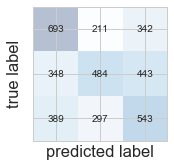

In [124]:
predictions=clf.predict(X_test_norm)


cm = metrics.confusion_matrix(y_test_10k, predictions)
print(cm)
fig, ax = plt.subplots(figsize=(2.5,2.5))
ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i, s=cm[i,j], va='center', ha='center')
plt.xlabel('predicted label')
plt.ylabel('true label')
ax.set_xticklabels([''] )
ax.set_yticklabels([''] )
plt.show()
plt.savefig('svc_first.png', dpi = 300)

In [125]:
#try one versus one and one versus rest
clf = svm.SVC(decision_function_shape='ovo') #one versus one
clf.fit(X_train_norm, y_train_10k) 

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovo', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

[[693 211 342]
 [348 484 443]
 [389 297 543]]


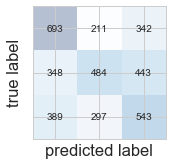

In [126]:
predictions=clf.predict(X_test_norm)


cm = metrics.confusion_matrix(y_test_10k, predictions)
print(cm)
fig, ax = plt.subplots(figsize=(2.5,2.5))
ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i, s=cm[i,j], va='center', ha='center')
plt.xlabel('predicted label')
plt.ylabel('true label')
ax.set_xticklabels([''] )
ax.set_yticklabels([''] )
plt.savefig('svm_ovo.png', dpi = 300)

In [130]:
predictions=clf.predict(X_test_norm)
print "----confusion matrix----"
print metrics.confusion_matrix(y_test_10k, predictions)
print 
print "----classification report----"
print metrics.classification_report(y_test_10k, predictions) 

----confusion matrix----
[[693 211 342]
 [348 484 443]
 [389 297 543]]

----classification report----
             precision    recall  f1-score   support

          0       0.48      0.56      0.52      1246
          1       0.49      0.38      0.43      1275
          2       0.41      0.44      0.42      1229

avg / total       0.46      0.46      0.46      3750



In [127]:
lin_clf = svm.LinearSVC()
lin_clf.fit(X_train_norm, y_train_10k) #one versus rest

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

[[695 236 315]
 [353 505 417]
 [415 327 487]]


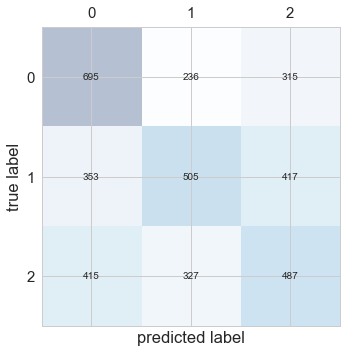

In [128]:
predictions=lin_clf.predict(X_test_norm)

labels = [0,1,2]
cm = metrics.confusion_matrix(y_test_10k, predictions)
print(cm)
fig, ax = plt.subplots(figsize=(5,5))
ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i, s=cm[i,j], va='center', ha='center')
plt.xlabel('predicted label')
plt.ylabel('true label')
ax.set_xticklabels([''] + labels )
ax.set_yticklabels([''] + labels)
fig.savefig('linclf_svm_cm.png', index = False, dpi = 300)

In [129]:
predictions=lin_clf.predict(X_test_norm)
print "----confusion matrix----"
print metrics.confusion_matrix(y_test_10k, predictions)
print 
print "----classification report----"
print metrics.classification_report(y_test_10k, predictions) 

----confusion matrix----
[[695 236 315]
 [353 505 417]
 [415 327 487]]

----classification report----
             precision    recall  f1-score   support

          0       0.48      0.56      0.51      1246
          1       0.47      0.40      0.43      1275
          2       0.40      0.40      0.40      1229

avg / total       0.45      0.45      0.45      3750



In [117]:
predictions=lin_clf.predict(allx_norm)

In [119]:
predictions

array([0, 2, 2, ..., 1, 1, 0], dtype=int64)

In [120]:
dfdiagdum2['linclfpred'] = predictions

In [122]:
dfdiagdum2[['target2', 'linclfpred']].head() #its not great...

,target2,linclfpred
0,0,0
1,2,2
2,0,2
3,0,2
4,0,1


## If I had more time I would do more basic analysis: which classes are acutally more similar ie. do readmission within 30 days and readmission > 30 days look more similar then not readmitted? Perhaps I grouped them incorrectly in my two class model. Try removing features: perhaps I am using too many features that just aren't very different across classes such as many of the drugs. Do simple statistical tests like ANOVA to test if certain features vary significantly across classes. Try dimensionality reduction. Try three classes with random forest and work more on parameter exploration in 3 class svm.